# Importing packages from the environment into the Notebook

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [2]:
import os
import kagglehub

# download latest version
path = kagglehub.dataset_download("goldenoakresearch/us-acs-mortgage-equity-loans-rent-statistics")

# walk through the directory to find real_estate_db.csv
real_estate_db_path = None
for root, dirs, files in os.walk(path):
    if "real_estate_db.csv" in files:
        real_estate_db_path = os.path.join(root, "real_estate_db.csv")
        break

if real_estate_db_path is None:
    raise ValueError("real_estate_db.csv not found in the downloaded dataset")

In [3]:
df = pd.read_csv(real_estate_db_path, encoding='latin-1') # imports the csv into the local notebook
df.head()

,UID,BLOCKID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
0,220336,NaN,140,16,2,Alaska,AK,Unalaska,Unalaska City,City,...,32.78177,31.91667,19.31875,440.46429,1894.0,0.25053,0.47388,0.30134,0.03443,0.09802
1,220342,NaN,140,20,2,Alaska,AK,Eagle River,Anchorage,City,...,38.97956,39.66667,20.05513,466.65478,1947.0,0.94989,0.52381,0.01777,0.00782,0.13575
2,220343,NaN,140,20,2,Alaska,AK,Jber,Anchorage,City,...,22.20427,23.16667,13.86575,887.67805,3570.0,0.00759,0.50459,0.06676,0.01000,0.01838
3,220345,NaN,140,20,2,Alaska,AK,Anchorage,Point Mackenzie,City,...,37.00750,34.00000,22.06347,281.49420,1049.0,0.20247,0.44428,0.05933,0.00000,0.21563
4,220347,NaN,140,20,2,Alaska,AK,Anchorage,Anchorage,City,...,34.96611,31.75000,20.49887,655.98066,2905.0,0.56936,0.51034,0.08315,0.06731,0.08711


# Cleaning the data

In [4]:
from scipy import stats

df.drop_duplicates(subset=None, inplace=True) # drops duplicate rows
df.drop('BLOCKID', axis=1, inplace=True) # drops an unnecessary column

df = df.replace(r'^\s*$', np.nan, regex=True) # turns null characters into nan
df.dropna(axis=0, inplace=True) # drops nan-filled columns

for i in ['hs_degree','debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']:
  df = df[np.abs(stats.zscore(df[i])) < 3] # drops outliers of values that break three standard deviations of the mean

df_sampled = df.sample(frac=0.01) # samples 0.01 of the db.

# Function to create a boolean from Graduation Rate

In [5]:
# write function to check whether or not the average person is graduated
def check_condition(value, threshold):
    if value > threshold:
        return 'Yes'
    else:
        return 'No'

# finds and prints the mean rate of hs_degree
hs_degree_mean = df_sampled['hs_degree'].mean()

# uses function to check whether values are greater or lesser and writes to new column
df_sampled['avg_person_graduated'] = df_sampled['hs_degree'].apply(lambda x: check_condition(x, hs_degree_mean))

# Neural Network

In [6]:
# defines X and y values for training
data_no_hs_degree = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']]
X = data_no_hs_degree
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

In [7]:
from sklearn.model_selection import train_test_split

# splits data into X and y trains and preds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from sklearn.metrics import accuracy_score

# defines network model
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# optimizer
initial_learning_rate = 0.001  # learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# learning rate scheduler
def lr_scheduler(epoch):
    return initial_learning_rate * 0.95 ** epoch

lr_callback = LearningRateScheduler(lr_scheduler)

# defines model compiler
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# trains model
model.fit(X_train, y_train, batch_size = 1, epochs = 100, callbacks=[lr_callback])

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5735 - loss: 1007.0573 - learning_rate: 0.0010
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5191 - loss: 132.0609 - learning_rate: 9.5000e-04
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6150 - loss: 60.5356 - learning_rate: 9.0250e-04
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5649 - loss: 104.9997 - learning_rate: 8.5737e-04
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6152 - loss: 88.1385 - learning_rate: 8.1451e-04
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5790 - loss: 87.4415 - learning_rate: 7.7378e-04
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6884 - loss: 48.8745 - learning_rate: 7.3509e-04
Epoch 8/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6314 - loss: 63.4917 - learning_rate: 6.9834e-04
Epoch 9/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6742

In [9]:
# performs predictions
y_hat = model.predict(X_test)
y_hat = [0 if val < 0.5 else 1 for val in y_hat]

# prints final accuracy
print(accuracy_score(y_test, y_hat))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0.6


In [10]:
accuracy_score(y_test, y_hat)

0.6

# Heatmap

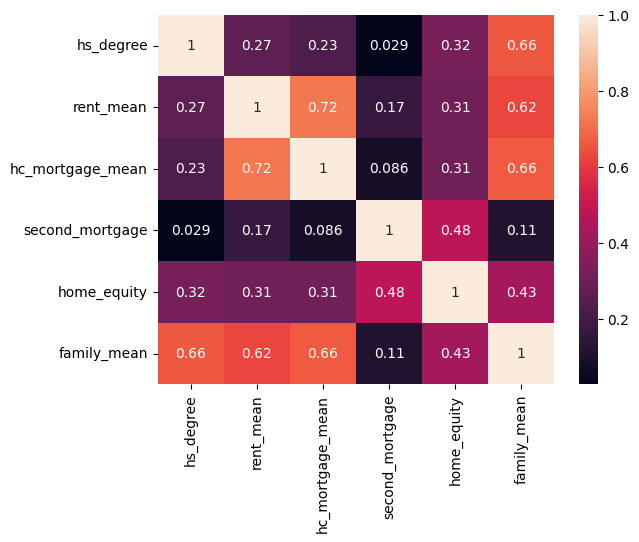

In [11]:
import matplotlib.pyplot as mp
import seaborn as sb
from PIL import _imaging
from PIL import Image

data = df_sampled[['hs_degree', 'rent_mean', 'hc_mortgage_mean', 'second_mortgage', 'home_equity', 'family_mean']]
dataplot=sb.heatmap(data.corr(), annot=True)
mp.show()

# Interactive US Map

In [12]:
import plotly.express as px
avg_grad_rates = df.groupby('state_ab')['hs_degree'].mean().reset_index()

fig = px.choropleth(avg_grad_rates,
                    locations='state_ab',
                    locationmode='USA-states',
                    color='hs_degree',
                    hover_name='state_ab',
                    color_continuous_scale='blues',
                    title='Average High School Graduation Rates by State')
fig.update_layout(geo_scope='usa')
fig.show()

# Scatterplot of Degree Percentage versus Debt Percentage

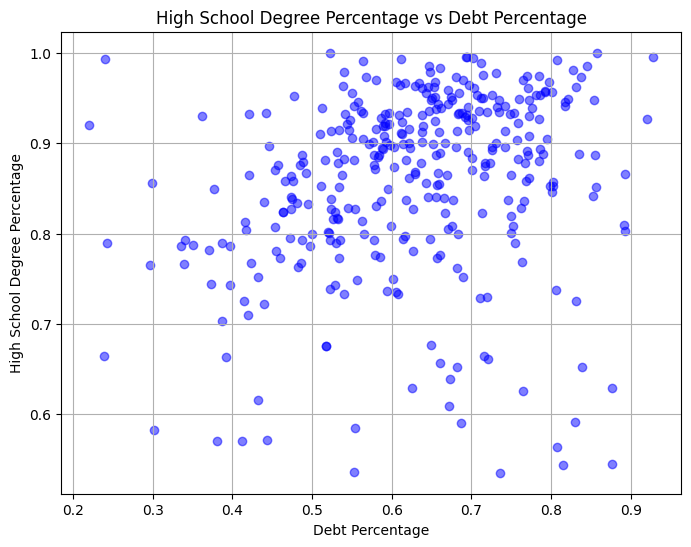

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['debt'], df_sampled['hs_degree'], color='b', alpha=0.5)
plt.title('High School Degree Percentage vs Debt Percentage')
plt.xlabel('Debt Percentage')
plt.ylabel('High School Degree Percentage')
plt.grid(True)
plt.show()

# Line Chart of Graduation Rate versus Debt Rate

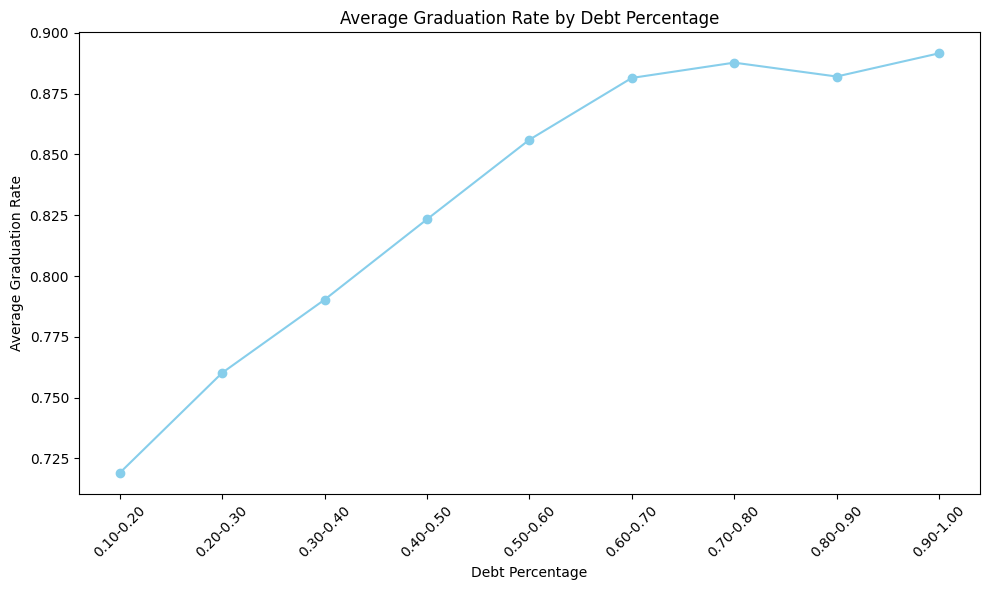

In [14]:
bins = np.linspace(0, 1, 11)
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]

df['debt_binned'] = pd.cut(df['debt'], bins=bins, labels=labels, right=False)

avg_graduation_rate = df.groupby('debt_binned', observed=True)['hs_degree'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_graduation_rate.index, avg_graduation_rate.values, marker='o', linestyle='-', color='skyblue')

plt.xlabel('Debt Percentage')
plt.ylabel('Average Graduation Rate')
plt.title('Average Graduation Rate by Debt Percentage')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Random Forest Classifier

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# identify the X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the random forest classifier
clf = RandomForestClassifier(random_state=42)

# trains the model
clf.fit(X_train, y_train)

# predicts values
y_pred = clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.81
Confusion Matrix:
[[24  9]
 [ 4 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        33
           1       0.79      0.89      0.84        37

    accuracy                           0.81        70
   macro avg       0.82      0.81      0.81        70
weighted avg       0.82      0.81      0.81        70



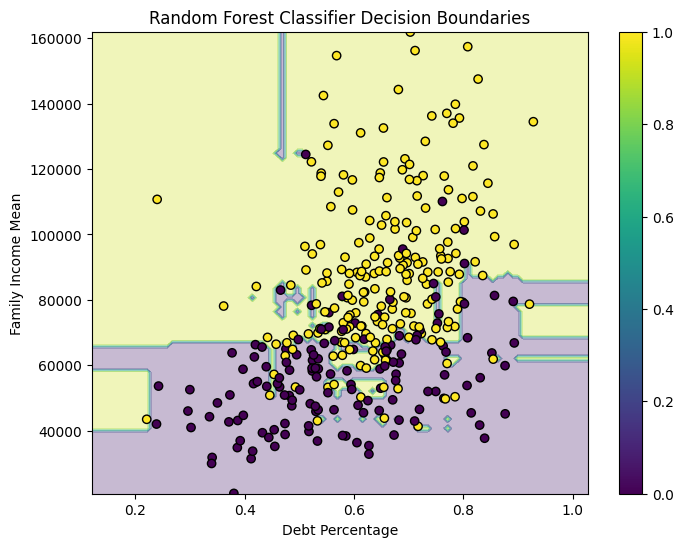

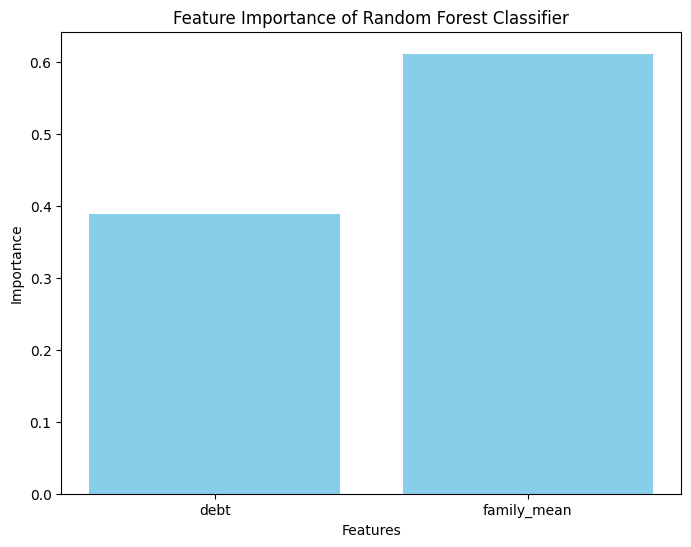

In [16]:
# plots boundaries
if X.shape[1] == 2:
    plt.figure(figsize=(8, 6))
    xx, yy = np.meshgrid(np.linspace(X.values[:, 0].min() - 0.1, X.values[:, 0].max() + 0.1, 100),
                         np.linspace(X.values[:, 1].min() - 100, X.values[:, 1].max() + 100, 100))
    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
    Z = clf.predict(grid_df).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap='viridis', edgecolors='k')
    plt.xlabel('Debt Percentage')
    plt.ylabel('Family Income Mean')
    plt.title('Random Forest Classifier Decision Boundaries')
    plt.colorbar()
    plt.show()

# plots features
plt.figure(figsize=(8, 6))
plt.bar(X.columns, clf.feature_importances_, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

# Decision Tree Classifier

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [18]:
# find X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

In [19]:
# separates data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# creates a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

In [21]:
# trains the classifier
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
# predicts X_test
y_pred = clf.predict(X_test)

In [23]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.73
Confusion Matrix:
[[23 10]
 [ 9 28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        33
           1       0.74      0.76      0.75        37

    accuracy                           0.73        70
   macro avg       0.73      0.73      0.73        70
weighted avg       0.73      0.73      0.73        70



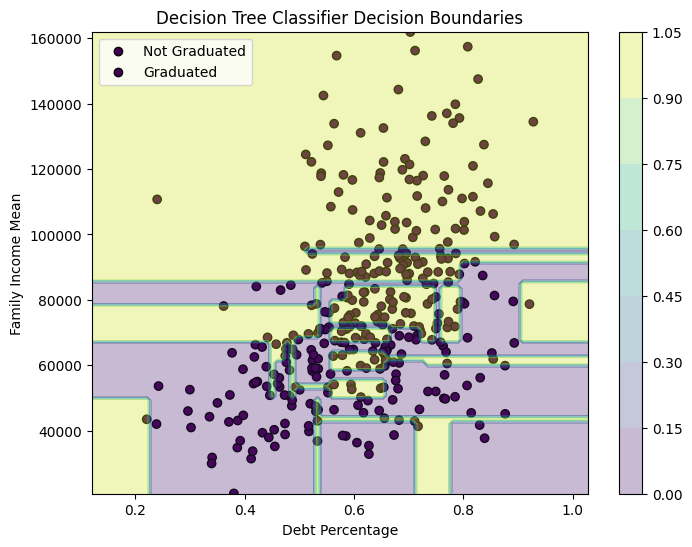

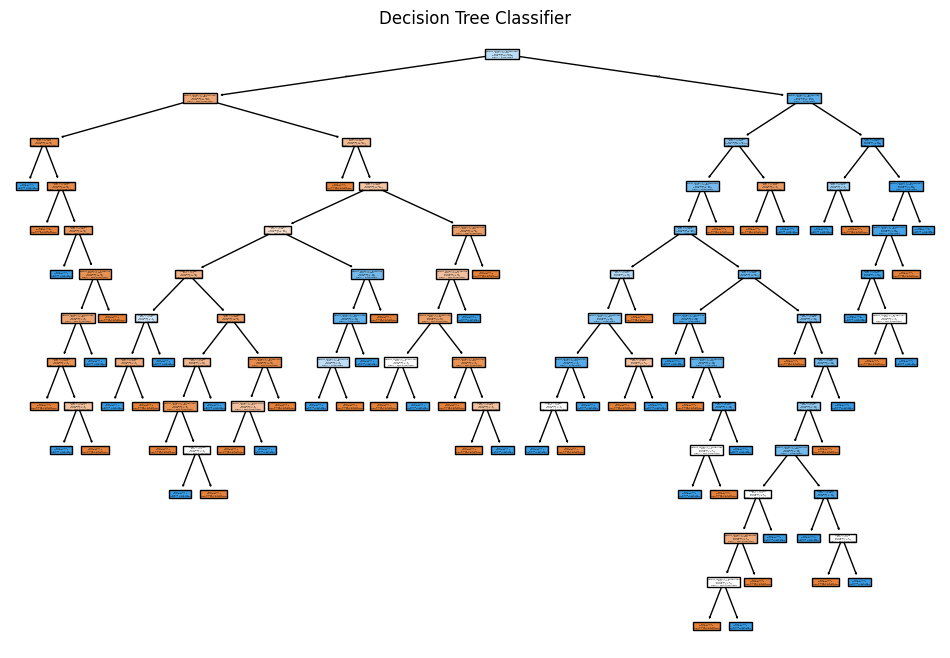

In [24]:
# plots the boundaries
plt.figure(figsize=(8, 6))

# plots points of each class
plt.scatter(X[y == 0]['debt'], X[y == 0]['family_mean'], c=y[y == 0], cmap='viridis', edgecolors='k', label='Not Graduated')
plt.scatter(X[y == 1]['debt'], X[y == 1]['family_mean'], c=y[y == 1], cmap='viridis', edgecolors='k', label='Graduated')

# creates a meshgrid to plot the decision boundaries
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100),
                     np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
Z = clf.predict(grid_df).reshape(xx.shape)

# plots the contour filled regions
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# labels and title
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Decision Tree Classifier Decision Boundaries')
plt.colorbar()
plt.legend()
plt.show()
# plots the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Graduated', 'Graduated'])
plt.title('Decision Tree Classifier')
plt.show()

# Pair Plot of Rent Mean versus Graduation Rate

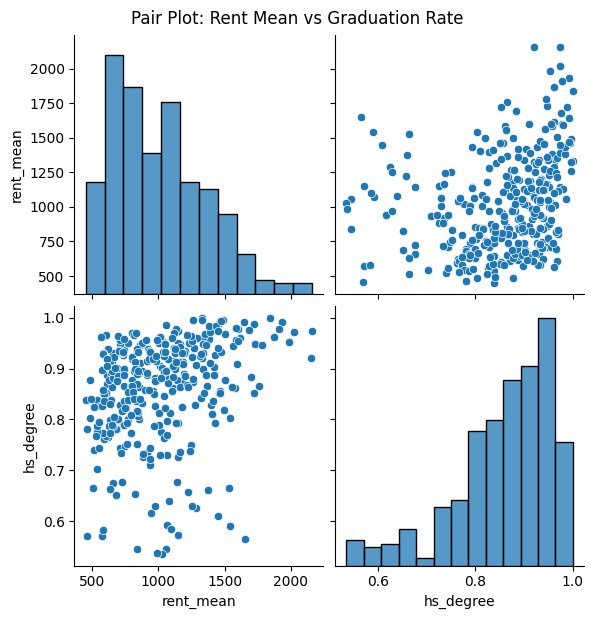

In [25]:
sb.pairplot(df_sampled[['rent_mean', 'hs_degree']], height=3)
plt.suptitle('Pair Plot: Rent Mean vs Graduation Rate', y=1.02)
plt.show()

# Joint Plot of Mortgage Mean versus Graduation Rate

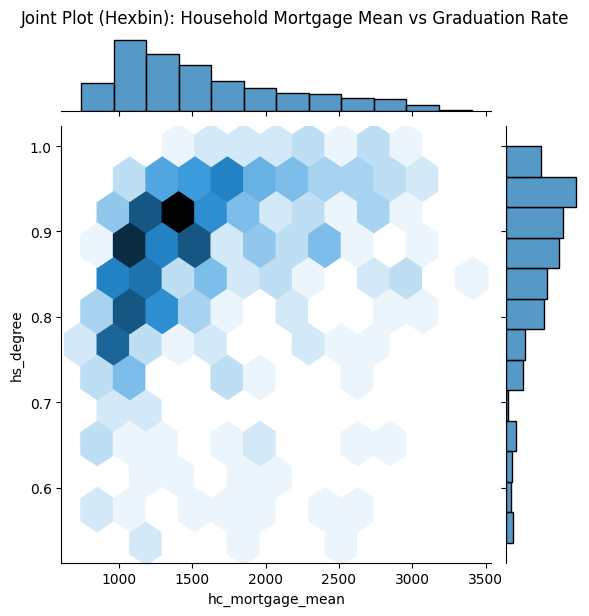

In [26]:
sb.jointplot(x='hc_mortgage_mean', y='hs_degree', data=df_sampled, kind='hex', height=6)
plt.suptitle('Joint Plot (Hexbin): Household Mortgage Mean vs Graduation Rate', y=1.02)
plt.show()

# Scatter Plot of Family Income Mean versus High School Degree Rate

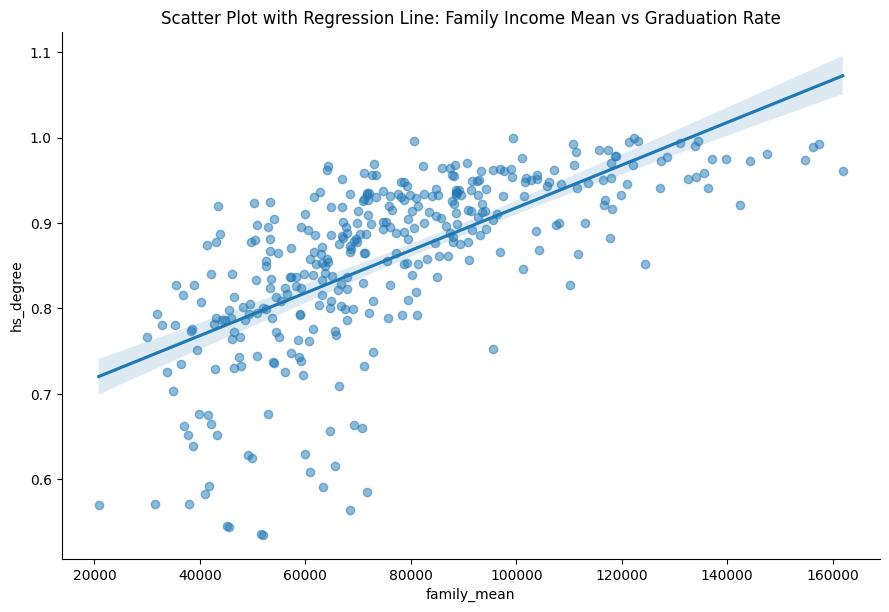

In [27]:
sb.lmplot(x='family_mean', y='hs_degree', data=df_sampled, height=6, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot with Regression Line: Family Income Mean vs Graduation Rate')
plt.show()